<a href="https://colab.research.google.com/github/Jahan2021/UCS-Classification/blob/main/UCS_Classification_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying usecases and nonusecases using Transformer

# Install Transformers Library

In [ ]:
!pip install transformers

In [ ]:
#checking for GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Load Dataset

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
path="/content/drive/MyDrive/Colab Notebooks"
from google.colab import drive
drive.mount('/content/drive')
path_data=path+"/data/ucsdata.csv"#"/content/spamdata_v2.csv"#"/content/spamdata_v2.txt"
df = pd.read_csv(path_data)
df.head()
#duplicate = df[df.duplicated()]
  
#print("Duplicate Rows :")
  
# Print the resultant Dataframe
#duplicate
#df.drop_duplicates()
df=df.drop_duplicates(keep='last', ignore_index=True)
df_not_usecase = df[df['label']==0]
df_not_usecase.shape
df_usecase = df[df['label']==1]
df_usecase.shape
#down sample the dataset to make it balanced
df_not_usecase_downsampled = df_not_usecase.sample(df_usecase.shape[0])
df_not_usecase_downsampled.shape
df_balanced = pd.concat([df_not_usecase_downsampled, df_usecase])
df_balanced.shape
df_balanced['label'].value_counts()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1    450
0    450
Name: label, dtype: int64

In [ ]:
# Selecting duplicate rows except first 
# occurrence based on all columns
duplicate = df_balanced[df_balanced.duplicated()]
  
print("Duplicate Rows :")
  
# Print the resultant Dataframe
duplicate
#df.drop_duplicates()

Duplicate Rows :


,label,text


In [ ]:
# turn a doc into clean tokens
def clean_doc(doc):
  doc = doc.lower()
  # split into tokens by white space
  tokens = doc.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  #stop_words = set(stopwords.words('english'))
  #tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return  (" ".join(tokens)).strip()+'.'

In [ ]:
import string
df_balanced["text"]=df_balanced["text"].apply(lambda x: clean_doc(x))
#df[1] = df[1].apply(add_one)

In [ ]:
df_balanced.head()

,label,text
513,0,when the option to merge the contents of the selected categories is selected the moved items must be updated in quickbooks pos.
460,0,however prefer to understand it like this user scenario is particular environment within specified use case.
473,0,in the password column user has to set the password if the document is protected and then reload the file.
450,0,to achieve an electronic clearing and settlement environment dvp all new instruments will be issued electronically dematerialised immobilised before sale and delivery into the primary market.
982,0,the reports they wish to submit from their offices.


## DistilledBERT

## Imports, Instalations and Constants

https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7

In [ ]:
#!pip install transformers

import pandas as pd
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

pd.set_option('display.max_colwidth', None)
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'# This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2.
BATCH_SIZE = 16
N_EPOCHS = 4 # we can put more, because evaluation of the model shows big difference in loss with accuracy 1.0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'], df_balanced['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df_balanced['label'])

# we will use temp_text and temp_labels to create validation and test set
#val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                #random_state=2018, 
                                                                #test_size=0.5, 
                                                                #stratify=temp_labels)

## Preprocess

### Decode byte arrays into string representation. 

In [ ]:
#X_train = X_train.apply(lambda x: str(x[0], 'utf-8'))
#X_test = X_test.apply(lambda x:  str(x[0], 'utf-8'))
X_train[:3]

25     user may choose to create new category to hold the moved categories.
595       this gives bobby the competition he requires and allows alice to.
495                         the unique tag must be at most characters long.
Name: text, dtype: object

### Max sentence length

In [ ]:
MAX_LEN = X_train.apply(lambda s: len([x for x in s.split()])).max()
MAX_LEN

63

## Encode with  DistilBertTokenizer

In [ ]:
#define a tokenizer object
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

#tokenize the text (padding to max sequence in batch)
train_encodings = tokenizer(list(X_train.values), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test.values), truncation=True, padding=True)

#print the first paragraph and it transformation
print(f'First paragraph: \'{X_train[:1]}\'')
print(f'Input ids: {train_encodings["input_ids"][0]}')
print(f'Attention mask: {train_encodings["attention_mask"][0]}')


First paragraph: '25    user may choose to create new category to hold the moved categories.
Name: text, dtype: object'
Input ids: [101, 5310, 2089, 5454, 2000, 3443, 2047, 4696, 2000, 2907, 1996, 2333, 7236, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Length check

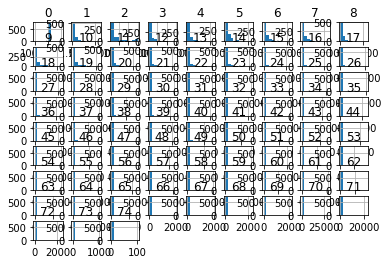

In [ ]:
pd.DataFrame(train_encodings["input_ids"]).hist();

In [ ]:
len(train_encodings["attention_mask"][0]) #max len tokenized sentence - 362

75

In [ ]:
#train_encodings

###  Turn our labels and encodings into a tf.Dataset object

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    list(y_train.values)))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                    list(y_test.values)))

In [ ]:
train_dataset 

<TensorSliceDataset shapes: ({input_ids: (75,), attention_mask: (75,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

## Fine-tuning with native TensorFlow


In [ ]:
model_dist = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions. 
model_dist.compile(optimizer=optimizerr,                                     
              loss=losss,
              metrics=['accuracy'])

hist=model_dist.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE), 
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          ) #([val_inp,val_mask],val_label)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_97']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
45/45 [==============================] - 22s 274ms/step - loss: 0.4842 - accuracy: 0.8250
Epoch 2/4
45/45 [==============================] - 12s 273ms/step - loss: 0.1354 - accuracy: 0.9528
Epoch 3/4
45/45 [==============================] - 12s 273ms/step - loss: 0.0805 - accuracy: 0.9694
Epoch 4/4
45/45 [==============================] - 12s 273ms/step - loss: 0.0204 - accuracy: 0.9931


In [ ]:
print(history.history)

{'loss': [0.018545327708125114, 0.025236956775188446, 0.019426949322223663, 0.021802255883812904], 'accuracy': [0.9902777671813965, 0.9930555820465088, 0.9958333373069763, 0.9930555820465088], 'val_loss': [0.1388854831457138, 0.3322078287601471, 0.25431209802627563, 0.19283756613731384], 'val_accuracy': [0.9666666388511658, 0.9166666865348816, 0.9333333373069763, 0.9333333373069763]}


In [ ]:
import matplotlib.pyplot as plt
# Create a dataframe
dist_metrics = pd.DataFrame(hist.history)

# Rename column
dist_metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    dist_metrics[[var1,var2]].plot()
    #dist_metrics[[var2]].plot()
    plt.title('DistilBERT Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

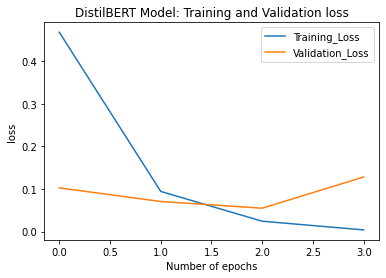

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plt.savefig("distBERT_loss.png")

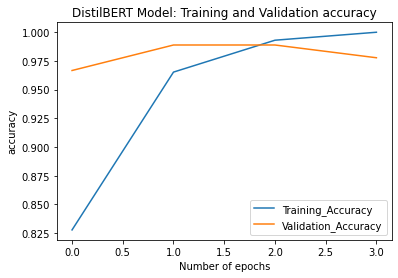

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')
plt.savefig("distBERT_accuray.png")

## Model Evaluation

In [ ]:
model_dist.evaluate(test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

12/12 [==============================] - 3s 74ms/step - loss: 0.2404 - accuracy: 0.9222


{'accuracy': 0.9222221970558167, 'loss': 0.24037620425224304}

## Predict on the different text examples

In [ ]:
def predict_proba(text_list, model, tokenizer):
  """
  To get array with predicted probabilities for 0 - instructions, 1- ingredients classes 
  for each paragraph in the list of strings
  :param text_list: list[str]
  :param model: transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertForSequenceClassification
  :param tokenizer: transformers.models.distilbert.tokenization_distilbert.DistilBertTokenizer
  :return res: numpy.ndarray
  """
     
  encodings = tokenizer(text_list, max_length=MAX_LEN, truncation=True, padding=True)
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings))) 
  preds = model.predict(dataset.batch(1)).logits
  res = tf.nn.softmax(preds, axis=1).numpy()
    
  return res

In [ ]:
predict_msg = ["User selects a transformation language program file to parse.",
"The HATS-GUI compares the time stamps on the lexical specification and grammar files to the time",
          "agentMom shall support the ability to send unicast message."]


In [ ]:
predict_proba(predict_msg, model_dist, tokenizer)

array([[4.2286605e-04, 9.9957711e-01],
       [1.6128378e-02, 9.8387170e-01],
       [9.9966896e-01, 3.3100366e-04]], dtype=float32)

In [ ]:
testT=["Store assistant checks status of the tape to be returned by customer. ","PDF Split and Merge was created prior to this document, so all requirements stated here are already satisfied.","Cashier enters item identifier.",
"System updates the sale line item."]

In [ ]:
pr=predict_proba(testT, model_dist, tokenizer)

In [ ]:
p=np.argmax(pr,axis=1)
print(p)

[1 0 1 1]


In [ ]:
#from srs document
preds_srs_dist=predict_proba(clean_text,model_dist,tokenizer)


In [ ]:
p_srs_dist=np.argmax(preds_srs_dist,axis=1)
print(p_srs_dist)

[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1
 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1
 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1
 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1]


In [ ]:
parr=p_srs_dist[p_srs_dist>0]
print(len(parr),len(clean_text))

256 442


In [ ]:
#pre=np.where(preds > 0.5, 1, 0)
df_ucs=get_UCS(clean_text,p_srs_dist)
print(df_ucs)

## ROC_AUC curv

In [ ]:
import numpy as np

encodings = tokenizer(X_test.values.tolist(), max_length=MAX_LEN, truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(encodings))) 
preds = model_dist.predict(dataset.batch(1)).logits


In [ ]:
from sklearn import metrics
targets=y_test
dist_fpr1, dist_tpr1, dist_thresh1 = metrics.roc_curve(targets, preds[:,1], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(targets))]
p_fpr, p_tpr, _ = metrics.roc_curve(targets, random_probs, pos_label=1)
auc_score1_dist = metrics.roc_auc_score(targets, preds[:,1])

In [ ]:
print(auc_score1_dist)

0.9861728395061728


In [ ]:
from sklearn.metrics import classification_report
p=np.argmax(preds,axis=1)
print(classification_report(targets, p))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        90
           1       0.93      0.91      0.92        90

    accuracy                           0.92       180
   macro avg       0.92      0.92      0.92       180
weighted avg       0.92      0.92      0.92       180



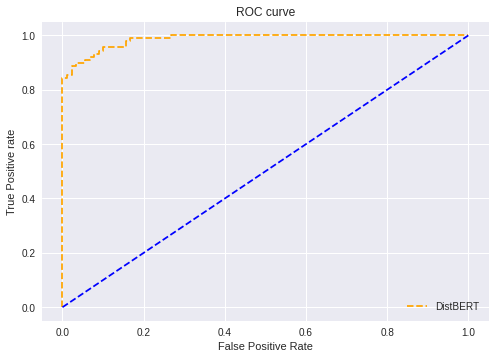

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(dist_fpr1, dist_tpr1, linestyle='--',color='orange', label='DistBERT')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

We take a txt file [here](https://github.com/Galina-Blokh/ai_assignment_aidock/blob/refator/data/test_links.txt). This file contains links to the recipe pages which our model didn't saw yet. Assuming you scraped data from the first [url](https://www.loveandlemons.com/green-bean-salad-recipe/). The data you feed into your model for prediction will be looking like in the cell below. (*A list with one first string of ingredients and following three strings with instructions.)

In [ ]:
# confusion matrix
cm=pd.crosstab(targets, p)

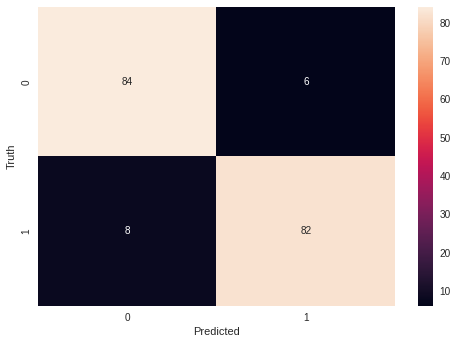

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('confusion.png')

## BERT Base Model
--https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df_balanced['text'], df_balanced['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df_balanced['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Tokenization

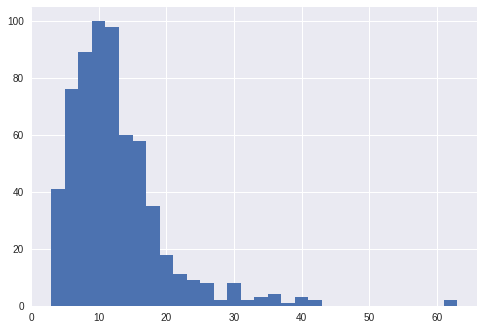

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
print(max(seq_len))
max_seq_len = max(seq_len)

63


In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)


In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
# loss function (no class weight is provided as the data is balanced)
cross_entropy  = nn.NLLLoss() 

# number of training epochs
epochs = 50

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50

Evaluating...

Training Loss: 1.028
Validation Loss: 1.756

 Epoch 2 / 50

Evaluating...

Training Loss: 0.831
Validation Loss: 0.709

 Epoch 3 / 50

Evaluating...

Training Loss: 0.708
Validation Loss: 0.696

 Epoch 4 / 50

Evaluating...

Training Loss: 0.703
Validation Loss: 0.693

 Epoch 5 / 50

Evaluating...

Training Loss: 0.696
Validation Loss: 0.694

 Epoch 6 / 50

Evaluating...

Training Loss: 0.696
Validation Loss: 0.693

 Epoch 7 / 50

Evaluating...

Training Loss: 0.699
Validation Loss: 0.700

 Epoch 8 / 50

Evaluating...

Training Loss: 0.699
Validation Loss: 0.693

 Epoch 9 / 50

Evaluating...

Training Loss: 0.700
Validation Loss: 0.693

 Epoch 10 / 50

Evaluating...

Training Loss: 0.695
Validation Loss: 0.693

 Epoch 11 / 50

Evaluating...

Training Loss: 0.693
Validation Loss: 0.693

 Epoch 12 / 50

Evaluating...

Training Loss: 0.693
Validation Loss: 0.693

 Epoch 13 / 50

Evaluating...

Training Loss: 0.693
Validation Loss: 0.693

 Epoch 14 / 50

Eval

KeyboardInterrupt: ignored

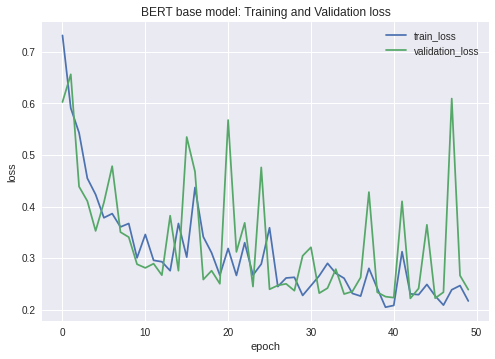

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('BERT base model: Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper right')
plt.show()


In [ ]:
plt.savefig("Bertbase_loss.png")

<Figure size 576x396 with 0 Axes>

# Load Saved Model

In [ ]:
#load weights of best model
model_path = 'saved_weights.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
print(preds)

In [ ]:
import numpy as np
y_predicted=np.argmax(preds,axis=1)
#y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0])

#AUC Curve

In [ ]:
from sklearn import metrics
# roc curve for models
targets=test_y
base_fpr1, base_tpr1, base_thresh1 = metrics.roc_curve(targets, preds[:,1], pos_label=1)
 
random_probs = [0 for i in range(len(targets))]
p_fpr, p_tpr, _ = metrics.roc_curve(targets, random_probs, pos_label=1)
auc_score1_base = metrics.roc_auc_score(targets, preds[:,1])
#auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1_base)

0.9802458296751536


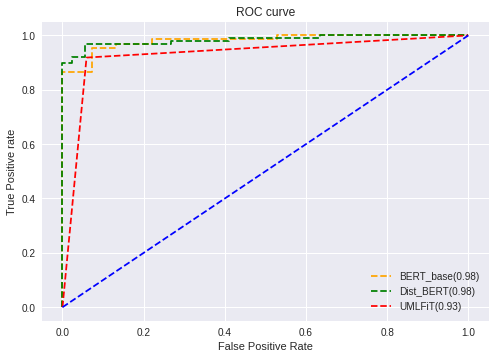

In [ ]:
#ROC AUC curve
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(base_fpr1, base_tpr1, linestyle='--',color='orange', label='BERT_base('+str(auc_score1_base.round(2))+')')
plt.plot(dist_fpr1, dist_tpr1, linestyle='--',color='green', label='Dist_BERT('+str(auc_score1_dist.round(2))+')')
plt.plot(umlfit_fpr,umlfit_tpr,linestyle='--',color='red', label='UMLFiT('+str(auc_umlfit.round(2))+')')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92        68
           1       0.89      0.96      0.92        67

    accuracy                           0.92       135
   macro avg       0.92      0.92      0.92       135
weighted avg       0.92      0.92      0.92       135



In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df = pandas.DataFrame(report).transpose()
#From here on, you are free to use the standard pandas methods to generate your desired output formats (CSV, HTML, LaTeX, ...).

In [ ]:
# confusion matrix
cm=pd.crosstab(test_y, preds)
cm

col_0,0,1
row_0,,
0,60,8
1,3,64


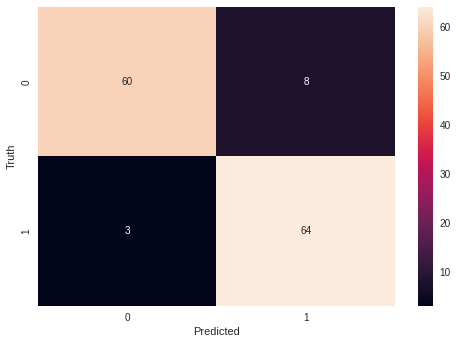

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('confusion.png')

In [ ]:
plt.savefig('confusion.png')

<Figure size 576x396 with 0 Axes>

In [ ]:
bert_base_model=model

In [ ]:
misclassified = [i for i in range(len(preds)) if preds[i] != targets[i]]

In [ ]:
t=test_text.to_numpy()
t

In [ ]:
missed=list()
for i in range(len(misclassified)):
  missed.append(t[misclassified[i]])
print(missed)

['the id of the item in pos is set to the category unique tag.', 'indicate if the called party was busy or if the network could not connect the call.', 'only one voucher is sold at time.', 'user should be able to register new account.', 'cursor display element in graphical user environment that marks location in window.', 'command line console could be useful for batch jobs server jobs.', 'the user wants to change the nature of the players in the current game with menu.', 'figure shows the general process as data.', 'this is system initiation process.', 'bar code the system will interface with the bar code reader to interface all transaction details.', 'no matched stock with the buy instruction.']


In [ ]:
print(len(missed))

11


# Prediction on Unseen Data

In [ ]:
#function for predecting unseen data
def predict_UCS(model,sentence):
  # tokenize and encode sequences in the test set
  tokens_test1 = tokenizer.batch_encode_plus(
      sentence,
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  # for test set
  test_seq = torch.tensor(tokens_test1['input_ids'])
  test_mask = torch.tensor(tokens_test1['attention_mask'])

  # get predictions for test data
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
    print(preds)
    preds = np.argmax(preds, axis = 1)

    return preds

In [ ]:
testString1=["Store assistant checks status of the tape to be returned by customer. ","PDF Split and Merge was created prior to this document, so all requirements stated here are already satisfied.","Cashier enters item identifier.",
"System updates the sale line item."]
predict_UCS(bert_base_model,testString1)


[[-5.5768046e+00 -3.7917639e-03]
 [-3.2627232e-02 -3.4388764e+00]
 [-6.7019224e+00 -1.2292456e-03]
 [-5.3776021e+00 -4.6296078e-03]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


array([1, 0, 1, 1])

In [ ]:
# The third one gives 0.99 indicating very high probabilty of spam
testString2 = ['User selects a transformation language program file to parse.',
'The HATS-GUI compares the time stamps on the lexical specification and grammar files to the time.',
          'agentMom shall support the ability to send unicast message.']
#predict_UCS(testT)
predict_UCS(bert_base_model,testString2)

[[-6.4206200e+00 -1.6289788e-03]
 [-9.3192440e-01 -5.0053734e-01]
 [-5.3022504e-02 -2.9634328e+00]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


array([1, 1, 0])

In [ ]:
df_ucs1=predict_UCS(bert_base_model,clean_text)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[-2.869563e-01 -1.388475e+00]
 [-1.611107e-02 -4.136297e+00]
 [-4.187387e-03 -5.477777e+00]
 [-1.751557e-03 -6.348099e+00]
 ...
 [-3.761624e-01 -1.159927e+00]
 [-1.133573e-02 -4.485458e+00]
 [-3.350018e-02 -3.412909e+00]
 [-1.204215e+00 -3.565713e-01]]


In [ ]:
print(len(df_ucs1))
#print(len(preds))

442


In [ ]:
pa=np.array(df_ucs1)
pa=pa[pa>0]
print(len(pa))

## ULMFiT_fastai_Text_Classification

In [ ]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

The one cycle and cyclic momentum allows the model to be trained on higher learning rates and converge faster. The one cycle policy provides some form of regularisation. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from fastai.text import *

In [ ]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df_balanced, stratify = df_balanced['label'], test_size = 0.3, random_state = 12)

Before proceeding further, we’ll need to prepare our data for the language model and for the classification model separately. The good news? This can be done quite easily using the fastai library:

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


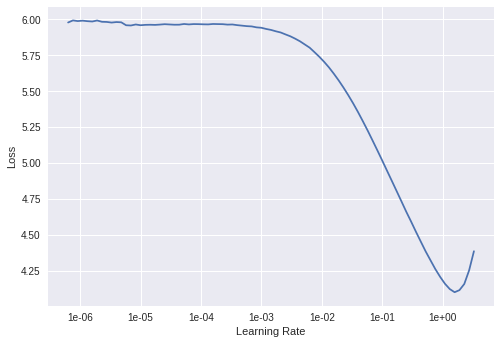

In [ ]:

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
#find the optimal learning rate & visualize it
learn.lr_find();
learn.recorder.plot();

By default, the Learner object is frozen thus we need to train the embeddings at first. Here, instead of running the cycle for one epoch, I am going to run it for 6 to see how accuracy varies. The learning rate I picked is with the help of the plot we got above.

In [ ]:
learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,5.917256,5.086357,0.174330,00:00
1,5.490161,4.088935,0.224777,00:00
2,4.917236,3.611097,0.295982,00:00
3,4.425104,3.414757,0.341295,00:00
4,4.057594,3.353779,0.356473,00:00
5,3.778625,3.334024,0.355357,00:00


We got very low accuracy, which was expected the rest of our model is still frozen but we can see that the accuracy is increasing.


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.520126,3.326334,0.362277,00:00
1,2.455014,3.779521,0.331920,00:00
2,2.570938,4.439612,0.285268,00:00
3,2.668116,3.953003,0.289509,00:00
4,2.581454,3.422284,0.369196,00:00
5,2.384816,3.472092,0.371875,00:00
6,2.185988,3.520568,0.365402,00:00
7,2.009004,3.568238,0.366741,00:00
8,1.861370,3.557034,0.373437,00:00
9,1.748183,3.558513,0.377232,00:00


Now we will test our model with random input & see if it’ll accurately complete the sentence.

In [ ]:
TEXT = "System updates the sale line item."# "The flight got delayed"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
#Save fine-tuned model for future use
learn.save_encoder('fine_tuned_enc')

System updates the sale line item. xxbos the system displays the list of the selected items that the original item will be split into . xxbos user selects option to parse refer to use case alt . xxbos the hats gui prompts the user to associate
System updates the sale line item. xxbos system displays plug in options to the administrator . xxbos member should be able to see the content they have published in all supported services . xxbos system prompts the sales person to fill out product name product i


Now, we’ll create a new data object that only grabs the labeled data and keeps those labels.

The classifier needs a little less dropout, so we pass drop_mult=0.5 to multiply all the dropouts by this amount. We don’t load the pre-trained model, but instead our fine-tuned encoder from the previous section.


In [ ]:
#data_clas.vocab.itos = data_lm.vocab.itos
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

Again we perform similar steps as Language mode. Here I am skipping the last 15 data points as I’m only interested till 1e-1.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


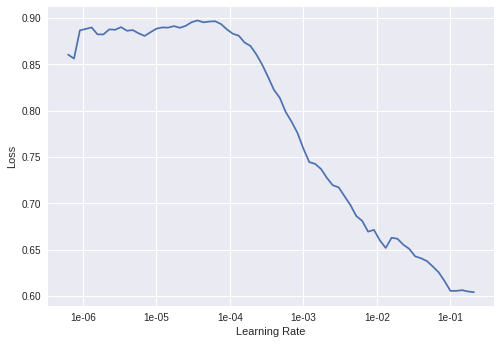

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


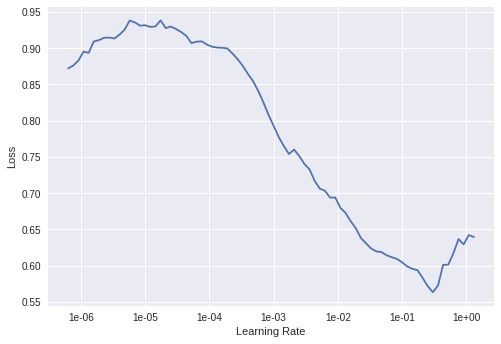

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=5)

learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

In [ ]:
#learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.766248,4.391377,0.258929,00:01
1,3.455055,5.942025,0.151562,00:00
2,4.947016,6.912456,0.016518,00:00
3,5.286956,5.601059,0.105804,00:00


Here we see that the accuracy has drastically improved if we compare with the Language model in step 1 when we provide labels.
Now we will partially train the model by unfreezing one layer at a time & differential learning rate. Here I am using the slice attribute which will divide the specified learning rates among 3 groups of models.

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.654473,0.459751,0.859259,00:01
1,0.459904,0.271152,0.925926,00:01
2,0.376010,0.219377,0.937037,00:01
3,0.336206,0.210937,0.937037,00:01


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

We see that the accuracy is improving gradually which is expected as we are gradually unfreezing the layers. More layers providing more depth.

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.355689,0.295547,0.896296,00:02
1,0.353004,0.228420,0.914815,00:02
2,0.279125,0.205954,0.922222,00:02
3,0.229406,0.202228,0.925926,00:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

Finally, we will unfreeze the whole model & visualize the learning rate to choose & use that for final training.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


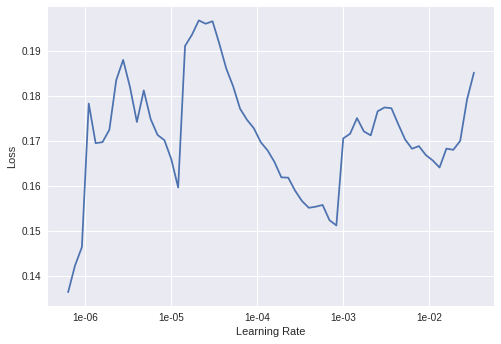

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('fwd_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.153969,0.187725,0.933333,00:02
1,0.140956,0.174568,0.925926,00:02
2,0.137828,0.184937,0.922222,00:02
3,0.128494,0.175116,0.929630,00:02
4,0.123485,0.170442,0.929630,00:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

We see that we have achieved maximum accuracy of 80% by the end of this model.

For our final results, we’ll take the average of the predictions of the model. Since the samples are sorted by text lengths for batching, we pass the argument ordered=True to get the predictions in the order of the texts.

In [ ]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)
accuracy(pred_fwd, lbl_fwd)

tensor(0.9296)

In [ ]:
print(np.argmax(pred_fwd[0]))

tensor(1)


In [ ]:
predictions = np.argmax(pred_fwd, axis = 1)
pd.crosstab(predictions, lbl_fwd)

col_0,0,1
row_0,,
0,127,11
1,8,124


In [ ]:
from sklearn.metrics import classification_report
# model's performance
#preds = np.argmax(preds, axis = 1)
print(classification_report(lbl_fwd, predictions))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       135
           1       0.94      0.92      0.93       135

    accuracy                           0.93       270
   macro avg       0.93      0.93      0.93       270
weighted avg       0.93      0.93      0.93       270



In [ ]:
misclassified = [i for i in range(len(predictions)) if predictions[i] != lbl_fwd[i]]

In [ ]:
t=df_val.to_numpy()


In [ ]:
misclassified

In [ ]:
missed=list()
for i in range(len(misclassified)):
  missed.append(t[misclassified[i]])
print(missed)

[array([1, 'condition there is problem in loading game or an artificial intelligence.'], dtype=object), array([1,
       'if the service requirements are acceptable according to the provider policy mediator passes it to the local pa.'],
      dtype=object), array([0,
       'finally the user selects the output file path or let the pdfsam create one by default to the same folder as one of the imported files.'],
      dtype=object), array([1, 'pas exchange accounting information to perform billing based on negotiated relationships.'], dtype=object), array([0, 'core set of files consisting of one lexical specification file one grammar file and zero or.'], dtype=object), array([0, 'when stock item category is updated the corresponding item is updated in quickbooks pos.'], dtype=object), array([0, 'the system must record every time receipt is printed or emailed.'], dtype=object), array([1, 'each cdn web server publishes resource and service information.'], dtype=object), array([1, 'all the 

In [ ]:
print(len(missed))

19


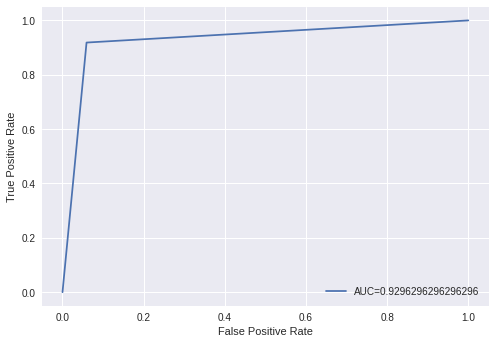

In [ ]:
from sklearn import metrics
#define metrics
#y_pred_proba = log_regression.predict_proba(X_test)[::,1]
umlfit_fpr, umlfit_tpr, _ = metrics.roc_curve(lbl_fwd,  predictions)
auc_umlfit = metrics.roc_auc_score(lbl_fwd,  predictions)

#create ROC curve
plt.plot(umlfit_fpr,umlfit_tpr,label="AUC="+str(auc_umlfit))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

We got the accuracy of 80.09%
Now it’s time to test our model with new text inputs & see how it performs!
The databunch has converted the text labels into numerical. They are as follows:
0 => Negative
1 => Neutral
2 => Positive

We see that our model has performed pretty well!!
You can test the model with negative as well as mixed sentiment text and verify results.


In [ ]:
t1 = "User selects a transformation language program file to 3 parse." 
t2="The HATS-GUI compares the time stamps on the lexical specification and grammar files to the time."
t3="agentMom shall 1-2 support the ability to send unicast message."
learn.predict(t1)

(Category tensor(1), tensor(1), tensor([0.0074, 0.9926]))

In [ ]:
def getUCS_UMLFiT(txt):
  preds=list()
  ucs=list()
  for t in txt:
    p=np.array(learn.predict(t)[2])
    #learn.predict
    #print(p)
    #pred1, lbl = learn.get_preds(ordered=True)
    p = np.argmax(p)
    preds.append(p)
  return preds

In [ ]:
T=["Store assistant checks status of the tape to be returned by customer. ","PDF Split and Merge was created prior to this document, so all requirements stated here are already satisfied.","Cashier enters item identifier.",
"System updates the sale line item."]
p=getUCS_UMLFiT(T)
print(p)

[1, 0, 1, 1]


In [ ]:
#predict UCS from SRS
print(clean_text[3])
#preds=predict_UCS(bert_base_model, clean_text)
#print(preds)
df_ucs=getUCS_UMLFiT(clean_text)
print(df_ucs)

this work is based upon the submissions of the spring cs.
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [ ]:
df_ucs

In [ ]:
pa=np.array(df_ucs)
pa=pa[pa>0]
print(len(pa))

232


# Detecting Use Cases from SRS documents

# Reading pdf file

In [ ]:
!pip install PyPDF2

In [ ]:
# importing required modules 
import PyPDF2 
def read_pdf_file(file_path):
  # importing required modules 
 
  text=""
  
  #path='/content/drive/My Drive/Colab Notebooks/casestudy/'
  # creating a pdf file object 
  pdfFileObj = open(file_path, 'rb') 
  #filename=path+"data_file.txt"
  #file_object = open(filename, 'a',errors="ignore")
    
  # creating a pdf reader object 
  pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
      
  # printing number of pages in pdf file 
  #print(pdfReader.numPages) 
  for i in range(pdfReader.numPages):    
    # creating a page object 
    pageObj = pdfReader.getPage(i) 
    text=text+ pageObj.extractText() 
    # extracting text from page 
    #print(pageObj.extractText()) 
  #file_object.write(text)    
  # closing the pdf file object 
  pdfFileObj.close()
  #file_object.close() 
  return text

In [ ]:
#Reading SRS pdf file
#path='/content/drive/My Drive/Colab Notebooks'
file_path=path+'/casestudy/2001 - hats.pdf'
text=read_pdf_file(file_path) 

In [ ]:
import string
import re
#Cleaning text 
def text_cleaner(text):
    # lower case text
    newString = text.lower()
    #newString = re.sub(r"'s\b","",newString)
    # remove punctuations
    newString = re.sub("[^a-zA-Z_]", " ", newString) 
    long_words=[]
    # remove short word
    for i in newString.split():
        if len(i)>=3:                  
            long_words.append(i)
    return (" ".join(long_words)).strip()+'.'




In [ ]:
#cleaning text
sent=text.split(".")
#print(len(sent))
clean_text=list()
for i in range(len(sent)):
  if len(sent[i])>3:
    #print(sent[i])
    clean_text.append(text_cleaner(sent[i]))
print(clean_text[0])

In [ ]:
#return list of UCS
def get_UCS(text,preds):
  df_test=list()
  #df_test = pd.DataFrame(text)
  #print(df_test)
  #df_test1=df_test[preds==1]
  #print(len(df_test))
  #df.head()
  for i in range( len(preds)):
    if preds[i]==1:
      print(text[i])
      df_test.append(text[i])
  return df_test

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# turn a doc into clean tokens
def clean_doc(doc):
  doc = doc.lower()
  # split into tokens by white space
  tokens = doc.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  #stop_words = set(stopwords.words('english'))
  #tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return  (" ".join(tokens)).strip()+'.'

In [ ]:
testString3 = "User selects a transformation language program file to 3 parse. \
The HATS-GUI compares the time stamps on the lexical specification and grammar files to the time. \
          agentMom shall 1-2 support the ability to send unicast message."


In [ ]:

#cleaning text
sent=testString3.split(".")
#print(len(sent))
clean_text=list()
for i in range(len(sent)):
  if len(sent[i])>3:
    #print(sent[i])
    clean_text.append(clean_doc(sent[i]))
print(clean_text)

['user selects transformation language program file to parse.', 'the hatsgui compares the time stamps on the lexical specification and grammar files to the time.', 'agentmom shall support the ability to send unicast message.']


In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r',errors='ignore')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
def get_cleantext(text):
  #cleaning text
  sent=text.split(".")
  #print(len(sent))
  clean_text=list()
  for i in range(len(sent)):
    if len(sent[i])>3:
      #print(sent[i])
      clean_text.append(clean_doc(sent[i]))
  return(clean_text)

In [ ]:
text=load_doc(path+"/data/SRSExample-webapp.txt")

In [ ]:
text[:100]

'Software Requirements Specification\n\nVersion 1.0\n<<Annotated Version>>\n\nApril 15, 2004\n\nWeb Publishi'

In [ ]:
clean_text=get_cleantext(text)

In [ ]:
print(clean_text[:100])

['software requirements specification version.', 'annotated version april web publishing system joan teamleader paul adams bobbie baker charles charlie submitted in partial fulfillment of the requirements of cs software engineering any comments inside double brackets such as these are not part of this srs but are comments upon this srs example to help the reader understand the point being made.', 'refer to the srs template for details on the purpose and rules for each section of this document.', 'this work is based upon the submissions of the spring cs.', 'the students who submitted these team projects were thomas clay dustin denney erjon dervishaj tiffanie dew blake guice jonathan medders marla medders tammie odom amro shorbatli joseph smith jay snellen chase tinney and stefanie watts.', 'table of contents table of contents list of figures ii.', 'introduction.', 'purpose.', 'scope of project.', 'glossary.', 'references.', 'overview of document.', 'overall description.', 'system enviro

In [ ]:
#predict UCS from SRS
print(clean_text)
preds=predict_UCS(bert_base_model, clean_text)
print(preds)
#df_ucs=get_UCS(clean_text,preds)
#print(df_ucs)

['software requirements specification version.', 'annotated version april web publishing system joan teamleader paul adams bobbie baker charles charlie submitted in partial fulfillment of the requirements of cs software engineering any comments inside double brackets such as these are not part of this srs but are comments upon this srs example to help the reader understand the point being made.', 'refer to the srs template for details on the purpose and rules for each section of this document.', 'this work is based upon the submissions of the spring cs.', 'the students who submitted these team projects were thomas clay dustin denney erjon dervishaj tiffanie dew blake guice jonathan medders marla medders tammie odom amro shorbatli joseph smith jay snellen chase tinney and stefanie watts.', 'table of contents table of contents list of figures ii.', 'introduction.', 'purpose.', 'scope of project.', 'glossary.', 'references.', 'overview of document.', 'overall description.', 'system enviro

NameError: ignored